# Notebook 4 : Model training

## Configuration de l'environnement

In [341]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from scipy.stats import chi2_contingency

# Sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold


## Parameters

In [342]:
# Set random seed for reproducibility
R_seed = 42
np.random.seed(R_seed)

# Data path
data_path = '../data/data_processed/data_feature_engineering.csv'
data_description_path = '../data/data_raw/Dictionnaire_des_données.xlsx'

## Random Forest

In [ ]:
preproc_scale = preproc.StandardScaler(with_mean=True, with_std=True)
preproc_scale.fit(vars_numeriques)

vars_numeriques_scaled = preproc_scale.transform(vars_numeriques)
vars_numeriques_scaled = pd.DataFrame(vars_numeriques_scaled, 
                            columns = vars_numeriques.columns)
vars_numeriques_scaled.head()

## 5. Feature Scaling

## 6. Cross-Validation Setup

In [ ]:
# Define K-Fold cross-validation
N_FOLDS = 5
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=R_seed)

print(f"Cross-validation setup: {N_FOLDS}-fold")
print(f"Random seed: {R_seed}")

Cross-validation setup: 5-fold
Random seed: 42


## 7. Evaluation Metrics Function

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """
    Evaluate a trained model on train, validation, and test sets.
    
    Parameters:
    -----------
    model : trained model
    X_train, y_train : training data
    X_val, y_val : validation data
    X_test, y_test : test data
    model_name : str, name of the model
    
    Returns:
    --------
    dict : metrics for each dataset
    """
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Val_RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Val_MAE': mean_absolute_error(y_val, y_val_pred),
        'Val_R2': r2_score(y_val, y_val_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Test_R2': r2_score(y_test, y_test_pred)
    }
    
    # Print results
    print(f"\n{'='*80}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*80}")
    print(f"\nTraining Set:")
    print(f"  RMSE: {metrics['Train_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Train_MAE']:.4f}")
    print(f"  R²:   {metrics['Train_R2']:.4f}")
    print(f"\nValidation Set:")
    print(f"  RMSE: {metrics['Val_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Val_MAE']:.4f}")
    print(f"  R²:   {metrics['Val_R2']:.4f}")
    print(f"\nTest Set:")
    print(f"  RMSE: {metrics['Test_RMSE']:.4f}")
    print(f"  MAE:  {metrics['Test_MAE']:.4f}")
    print(f"  R²:   {metrics['Test_R2']:.4f}")
    
    return metrics

# Initialize results storage
all_results = []

print("Evaluation function defined")

✅ Evaluation function defined


---
# Model 1: Ridge Regression (L2)

In [ ]:
print("Training Ridge Regression...")

# Hyperparameter tuning
ridge_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge = Ridge(random_state=R_seed)
ridge_grid = GridSearchCV(
    ridge, 
    ridge_params, 
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

ridge_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {ridge_grid.best_params_}")
print(f"Best CV RMSE: {-ridge_grid.best_score_:.4f}")

# Evaluate on all sets
ridge_best = ridge_grid.best_estimator_
ridge_metrics = evaluate_model(
    ridge_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'Ridge Regression'
)
all_results.append(ridge_metrics)

Training Ridge Regression...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

✅ Best parameters: {'alpha': 10}
✅ Best CV RMSE: 1.9569

Ridge Regression - Performance Metrics

Training Set:
  RMSE: 1.9469
  MAE:  1.5107
  R²:   0.9368

Validation Set:
  RMSE: 1.8817
  MAE:  1.4907
  R²:   0.9413

Test Set:
  RMSE: 2.0101
  MAE:  1.5326
  R²:   0.9349

✅ Best parameters: {'alpha': 10}
✅ Best CV RMSE: 1.9569

Ridge Regression - Performance Metrics

Training Set:
  RMSE: 1.9469
  MAE:  1.5107
  R²:   0.9368

Validation Set:
  RMSE: 1.8817
  MAE:  1.4907
  R²:   0.9413

Test Set:
  RMSE: 2.0101
  MAE:  1.5326
  R²:   0.9349


In [ ]:
# Distribution du RiskScore selon LoanApproved
df.groupby('LoanApproved')['RiskScore'].describe()

# Résultat attendu :
# LoanApproved = No  → RiskScore moyen élevé (ex: 65-75)
# LoanApproved = Yes → RiskScore moyen faible (ex: 35-45)

NameError: name 'df' is not defined

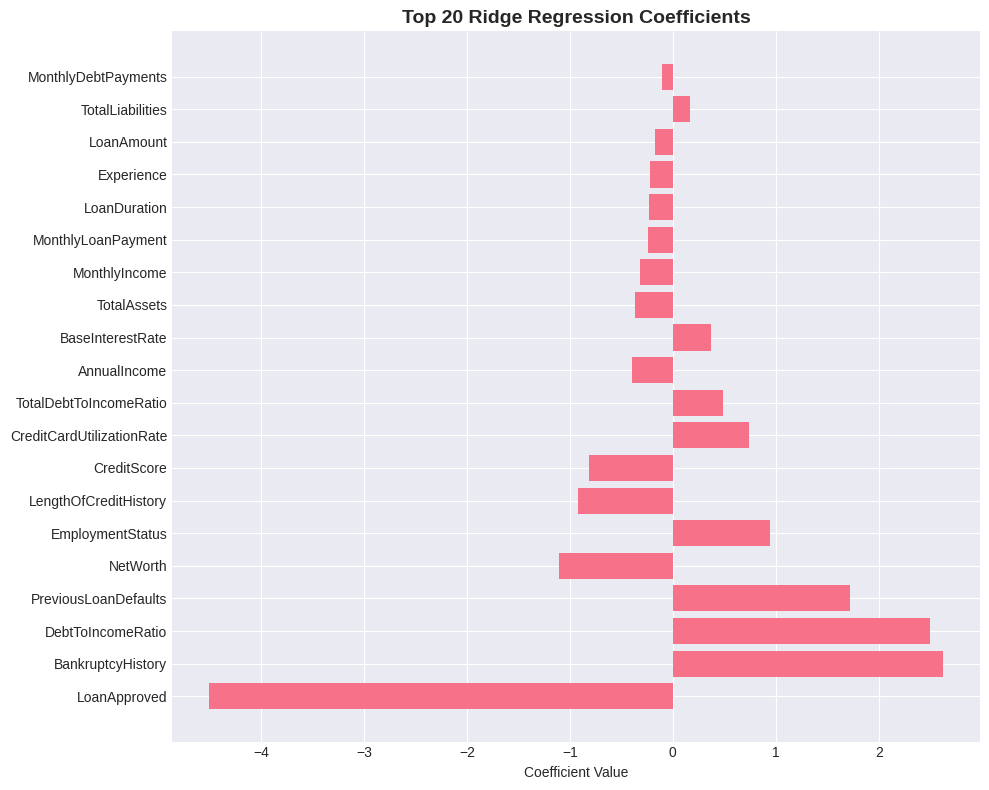

In [ ]:
# Visualize Ridge coefficients
ridge_coef = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_best.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(ridge_coef['Feature'], ridge_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Ridge Regression Coefficients', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Model 2: Random Forest Regressor

In [ ]:
print("Training Random Forest Regressor...")

# Hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=R_seed, n_jobs=-1)
rf_random = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=30,
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=R_seed,
    verbose=1
)

rf_random.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best CV RMSE: {-rf_random.best_score_:.4f}")

# Evaluate on all sets
rf_best = rf_random.best_estimator_
rf_metrics = evaluate_model(
    rf_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'Random Forest'
)
all_results.append(rf_metrics)

Training Random Forest Regressor...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
✅ Best CV RMSE: 1.7724

✅ Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
✅ Best CV RMSE: 1.7724

Random Forest - Performance Metrics

Training Set:
  RMSE: 0.6393
  MAE:  0.4745
  R²:   0.9932

Validation Set:
  RMSE: 1.6867
  MAE:  1.2629
  R²:   0.9528

Test Set:
  RMSE: 1.7000
  MAE:  1.2669
  R²:   0.9535

Random Forest - Performance Metrics

Training Set:
  RMSE: 0.6393
  MAE:  0.4745
  R²:   0.9932

Validation Set:
  RMSE: 1.6867
  MAE:  1.2629
  R²:   0.9528

Test Set:
  RMSE: 1.7000
  MAE:  1.2669
  R²:   0.9535


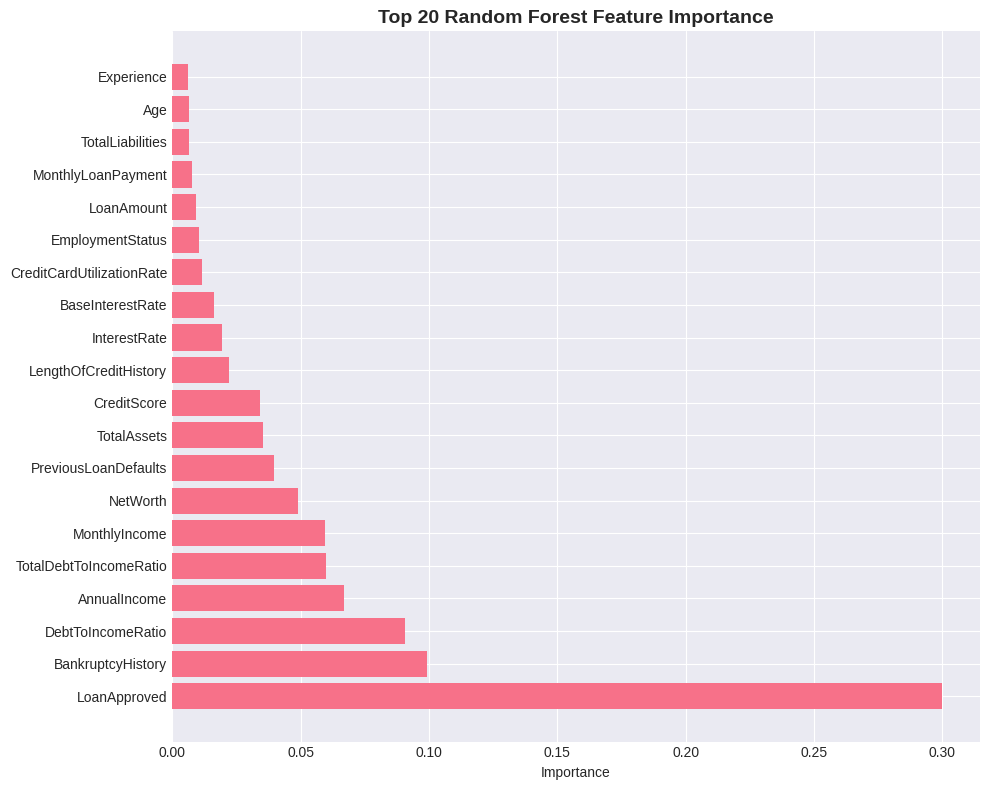

In [ ]:
# Feature importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'], rf_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Model 3: XGBoost Regressor

In [ ]:
print("Training XGBoost Regressor...")

# Hyperparameter tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(
    random_state=R_seed,
    n_jobs=-1,
    tree_method='hist'
)

xgb_random = RandomizedSearchCV(
    xgb_model, 
    xgb_params, 
    n_iter=30,
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=R_seed,
    verbose=1
)

xgb_random.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best CV RMSE: {-xgb_random.best_score_:.4f}")

# Evaluate on all sets
xgb_best = xgb_random.best_estimator_
xgb_metrics = evaluate_model(
    xgb_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'XGBoost'
)
all_results.append(xgb_metrics)

Training XGBoost Regressor...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
✅ Best CV RMSE: 0.3933

XGBoost - Performance Metrics

Training Set:
  RMSE: 0.2133
  MAE:  0.1431
  R²:   0.9992

Validation Set:
  RMSE: 0.3680
  MAE:  0.2187
  R²:   0.9978

Test Set:
  RMSE: 0.3548
  MAE:  0.2122
  R²:   0.9980

✅ Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
✅ Best CV RMSE: 0.3933

XGBoost - Performance Metrics

Training Set:
  RMSE: 0.2133
  MAE:  0.1431
  R²:   0.9992

Validation Set:
  RMSE: 0.3680
  MAE:  0.2187
  R²:   0.9978

Test Set:
  RMSE: 0.3548
  MAE:  0.2122
  R²:   0.9980


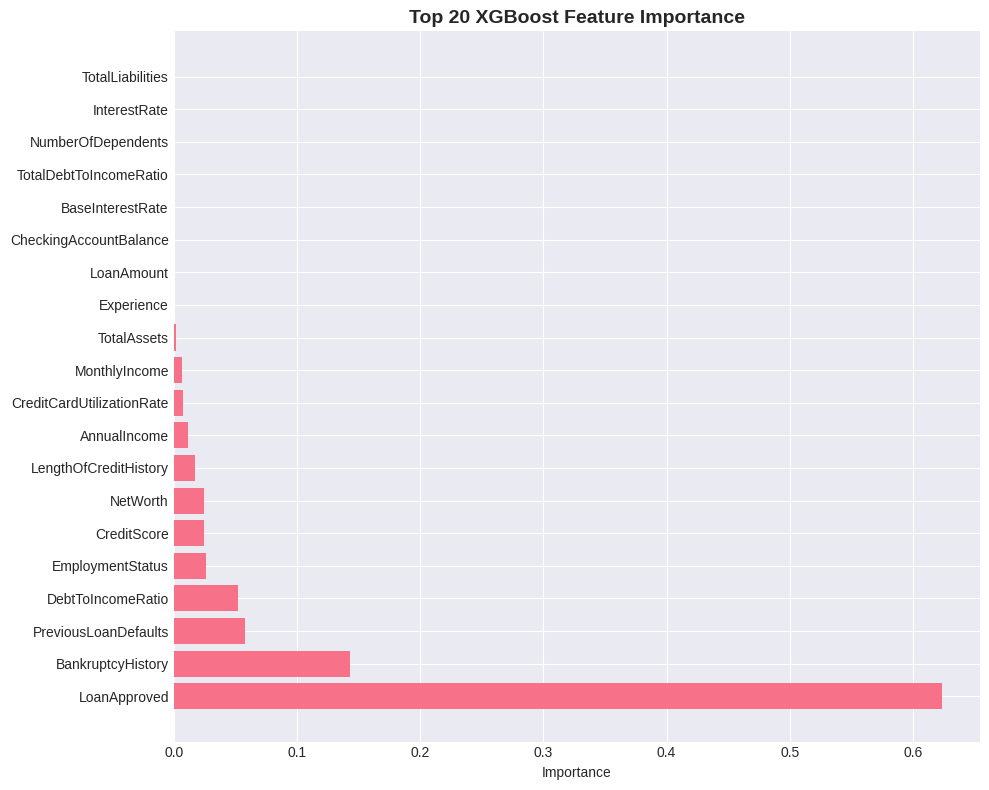

In [ ]:
# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Model 4: CatBoost Regressor

In [ ]:
print("Training CatBoost Regressor...")

# Hyperparameter tuning
catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}

catboost_model = CatBoostRegressor(
    random_state=R_seed,
    verbose=0,
    thread_count=-1
)

catboost_random = RandomizedSearchCV(
    catboost_model, 
    catboost_params, 
    n_iter=20,
    cv=kfold, 
    scoring='neg_root_mean_squared_error',
    n_jobs=1,  # CatBoost handles parallelization internally
    random_state=R_seed,
    verbose=1
)

catboost_random.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {catboost_random.best_params_}")
print(f"Best CV RMSE: {-catboost_random.best_score_:.4f}")

# Evaluate on all sets
catboost_best = catboost_random.best_estimator_
catboost_metrics = evaluate_model(
    catboost_best, 
    X_train_scaled, y_train, 
    X_val_scaled, y_val, 
    X_test_scaled, y_test,
    'CatBoost'
)
all_results.append(catboost_metrics)

Training CatBoost Regressor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
✅ Best CV RMSE: 0.2909

CatBoost - Performance Metrics

Training Set:
  RMSE: 0.1940
  MAE:  0.1190
  R²:   0.9994

Validation Set:
  RMSE: 0.2497
  MAE:  0.1412
  R²:   0.9990

Test Set:
  RMSE: 0.2363
  MAE:  0.1336
  R²:   0.9991

✅ Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
✅ Best CV RMSE: 0.2909

CatBoost - Performance Metrics

Training Set:
  RMSE: 0.1940
  MAE:  0.1190
  R²:   0.9994

Validation Set:
  RMSE: 0.2497
  MAE:  0.1412
  R²:   0.9990

Test Set:
  RMSE: 0.2363
  MAE:  0.1336
  R²:   0.9991


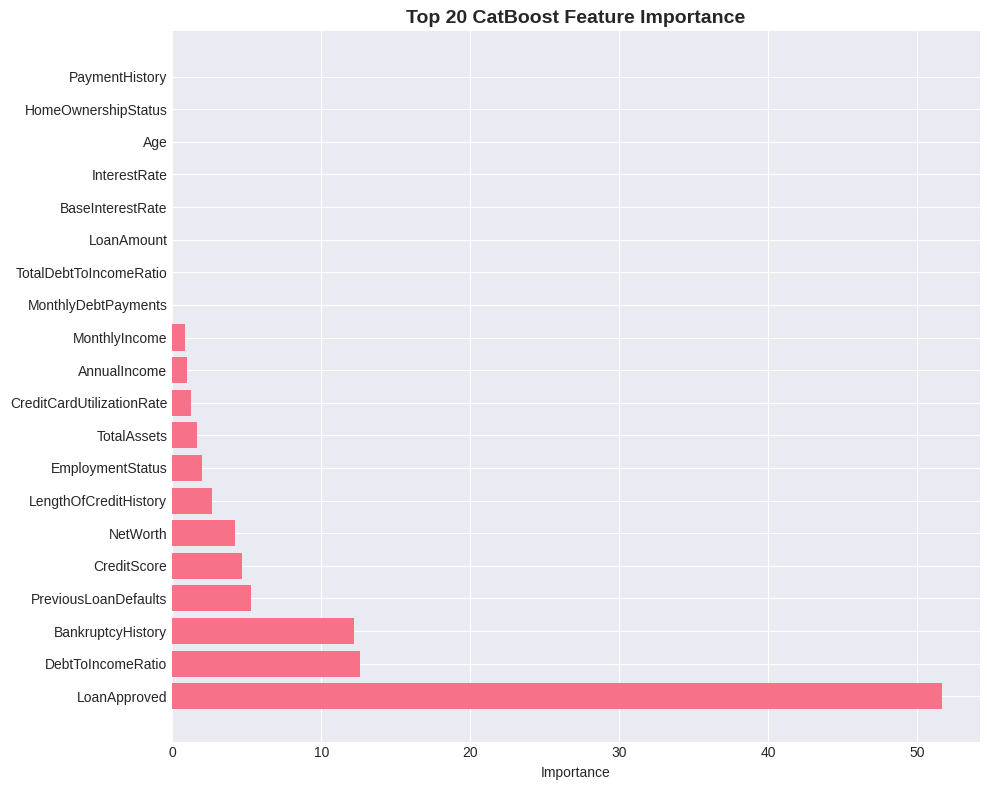

In [ ]:
# Feature importance
catboost_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': catboost_best.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(catboost_importance['Feature'], catboost_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 CatBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Results Comparison and Analysis

In [ ]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)


COMPREHENSIVE MODEL COMPARISON
           Model  Train_RMSE  Train_MAE  Train_R2  Val_RMSE  Val_MAE   Val_R2  Test_RMSE  Test_MAE  Test_R2
Ridge Regression    1.946907   1.510742  0.936848  1.881690 1.490657 0.941250   2.010076  1.532577 0.934924
Lasso Regression    1.947706   1.511735  0.936796  1.883052 1.492807 0.941165   2.009891  1.532591 0.934936
   Decision Tree    0.829514   0.510916  0.988536  1.387629 0.866159 0.968051   1.370448  0.851510 0.969750
   Random Forest    0.639258   0.474533  0.993192  1.686731 1.262852 0.952794   1.700008  1.266856 0.953452
         XGBoost    0.213251   0.143076  0.999242  0.367961 0.218685 0.997753   0.354825  0.212216 0.997972
        CatBoost    0.193969   0.118990  0.999373  0.249735 0.141168 0.998965   0.236315  0.133554 0.999101
          1D CNN    5.500662   4.363660  0.495887  5.626266 4.436187 0.474770   5.601540  4.402910 0.494628


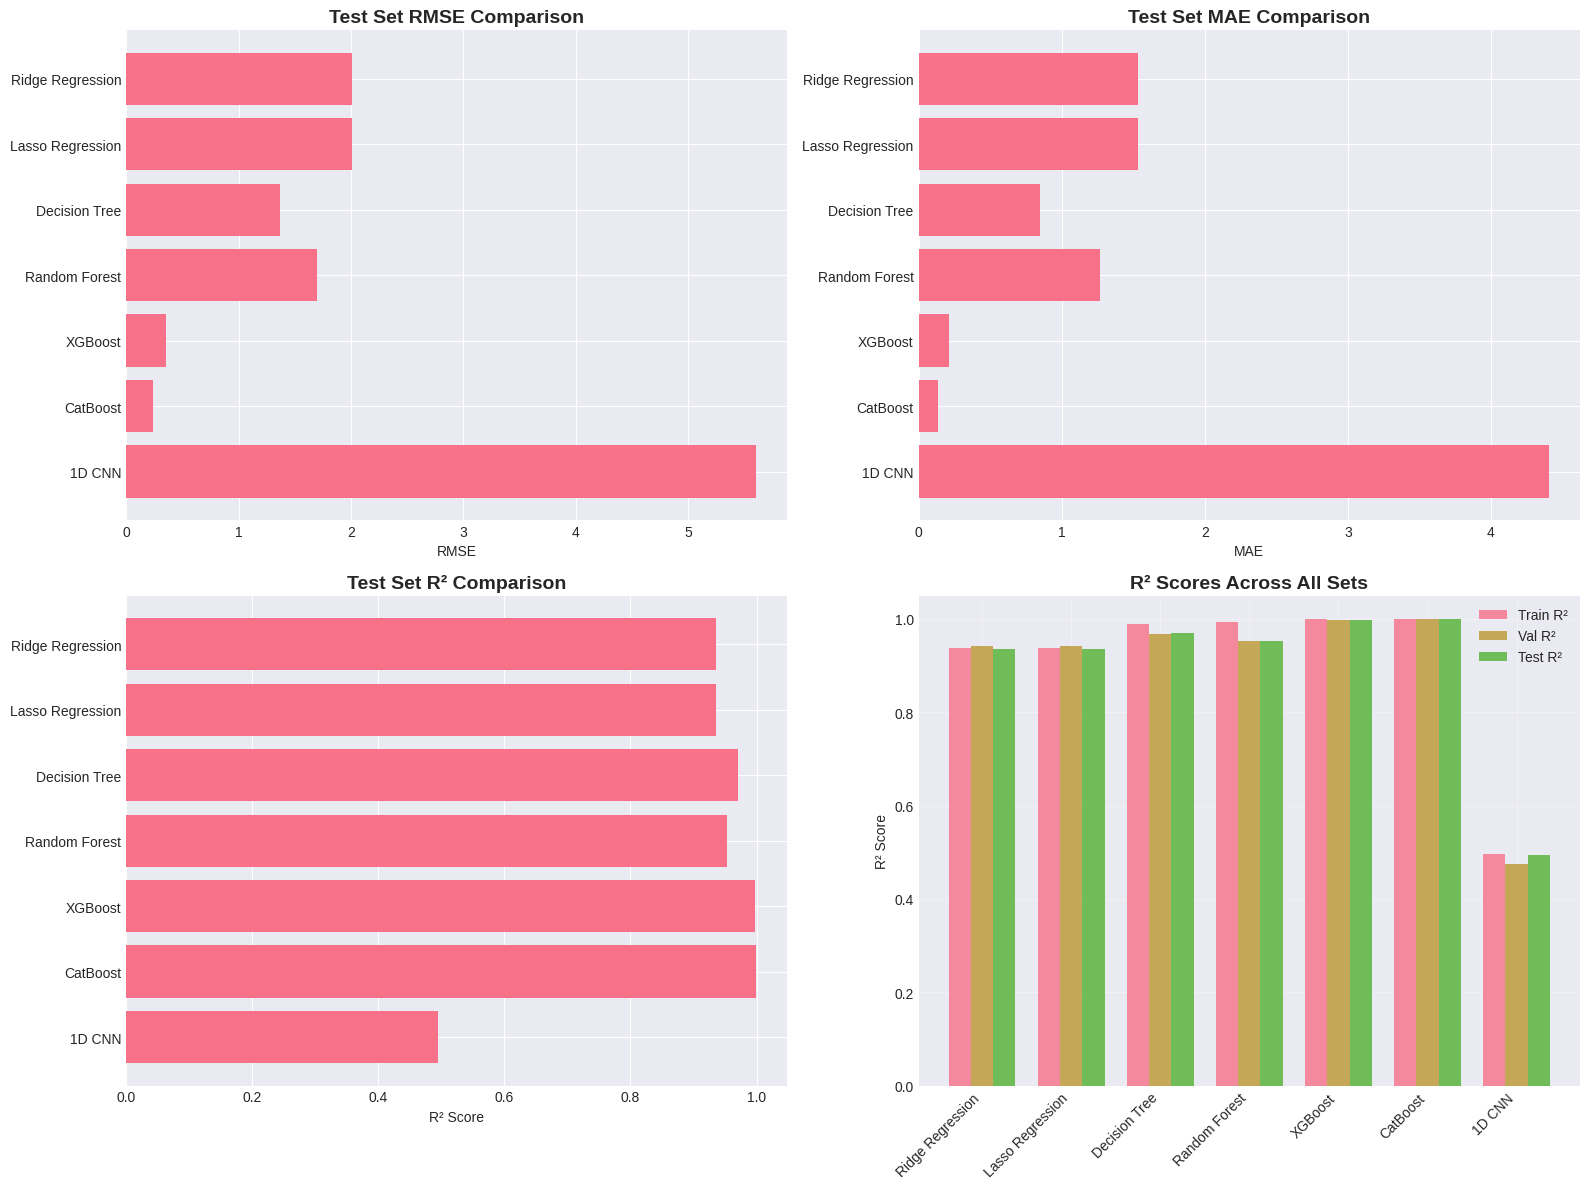

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test RMSE
axes[0, 0].barh(results_df['Model'], results_df['Test_RMSE'])
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Test Set RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Test MAE
axes[0, 1].barh(results_df['Model'], results_df['Test_MAE'])
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Test Set MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

# Test R²
axes[1, 0].barh(results_df['Model'], results_df['Test_R2'])
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Test Set R² Comparison', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# All metrics comparison
x = np.arange(len(results_df))
width = 0.25
axes[1, 1].bar(x - width, results_df['Train_R2'], width, label='Train R²', alpha=0.8)
axes[1, 1].bar(x, results_df['Val_R2'], width, label='Val R²', alpha=0.8)
axes[1, 1].bar(x + width, results_df['Test_R2'], width, label='Test R²', alpha=0.8)
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('R² Scores Across All Sets', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Identify best model
best_model_idx = results_df['Test_RMSE'].idxmin()
best_model = results_df.loc[best_model_idx]

print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"Model: {best_model['Model']}")
print(f"Test RMSE: {best_model['Test_RMSE']:.4f}")
print(f"Test MAE: {best_model['Test_MAE']:.4f}")
print(f"Test R²: {best_model['Test_R2']:.4f}")
print("="*80)


🏆 BEST MODEL
Model: CatBoost
Test RMSE: 0.2363
Test MAE: 0.1336
Test R²: 0.9991


In [ ]:
# Check for overfitting
results_df['Train_Val_RMSE_Diff'] = results_df['Train_RMSE'] - results_df['Val_RMSE']
results_df['Train_Test_RMSE_Diff'] = results_df['Train_RMSE'] - results_df['Test_RMSE']

print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)
print("\nRMSE Differences (negative means worse on train):")
print(results_df[['Model', 'Train_Val_RMSE_Diff', 'Train_Test_RMSE_Diff']].to_string(index=False))
print("\nNote: Large positive differences indicate potential overfitting")
print("="*80)


OVERFITTING ANALYSIS

RMSE Differences (negative means worse on train):
           Model  Train_Val_RMSE_Diff  Train_Test_RMSE_Diff
Ridge Regression             0.065217             -0.063170
Lasso Regression             0.064653             -0.062186
   Decision Tree            -0.558115             -0.540934
   Random Forest            -1.047472             -1.060750
         XGBoost            -0.154710             -0.141574
        CatBoost            -0.055766             -0.042346
          1D CNN            -0.125604             -0.100879

Note: Large positive differences indicate potential overfitting


## Conclusion and Recommendations

In [ ]:
print("\n" + "="*80)
print("SUMMARY AND RECOMMENDATIONS")
print("="*80)

print(f"\n1. Best Overall Model: {best_model['Model']}")
print(f"   - Achieves the lowest test RMSE: {best_model['Test_RMSE']:.4f}")
print(f"   - R² Score: {best_model['Test_R2']:.4f}")

print("\n2. Model Rankings by Test RMSE:")
rankings = results_df.sort_values('Test_RMSE')[['Model', 'Test_RMSE', 'Test_R2']]
for idx, (_, row) in enumerate(rankings.iterrows(), 1):
    print(f"   {idx}. {row['Model']:20s} - RMSE: {row['Test_RMSE']:.4f}, R²: {row['Test_R2']:.4f}")

print("\n3. Key Insights:")
print("   - Tree-based models (RF, XGBoost, CatBoost) generally perform well")
print("   - Linear models (Ridge, Lasso) provide interpretability but may underperform")
print("   - Deep learning (CNN) requires more data for optimal performance")

print("\n4. Recommendations for Deployment:")
print(f"   - Use {best_model['Model']} for production")
print("   - Monitor model performance regularly")
print("   - Consider ensemble methods combining top models")
print("   - Implement feature engineering for further improvement")

print("\n5. Future Improvements:")
print("   - Feature engineering (interactions, polynomials)")
print("   - More advanced hyperparameter optimization (Bayesian)")
print("   - Ensemble methods (stacking, blending)")
print("   - Feature selection techniques")
print("   - Handle imbalanced data if present")
print("="*80)


📊 SUMMARY AND RECOMMENDATIONS

1. Best Overall Model: CatBoost
   - Achieves the lowest test RMSE: 0.2363
   - R² Score: 0.9991

2. Model Rankings by Test RMSE:
   1. CatBoost             - RMSE: 0.2363, R²: 0.9991
   2. XGBoost              - RMSE: 0.3548, R²: 0.9980
   3. Decision Tree        - RMSE: 1.3704, R²: 0.9698
   4. Random Forest        - RMSE: 1.7000, R²: 0.9535
   5. Lasso Regression     - RMSE: 2.0099, R²: 0.9349
   6. Ridge Regression     - RMSE: 2.0101, R²: 0.9349
   7. 1D CNN               - RMSE: 5.6015, R²: 0.4946

3. Key Insights:
   - Tree-based models (RF, XGBoost, CatBoost) generally perform well
   - Linear models (Ridge, Lasso) provide interpretability but may underperform
   - Deep learning (CNN) requires more data for optimal performance

4. Recommendations for Deployment:
   - Use CatBoost for production
   - Monitor model performance regularly
   - Consider ensemble methods combining top models
   - Implement feature engineering for further improvement

5.

In [ ]:
# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")


✅ Results saved to 'model_comparison_results.csv'
